In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tstrippy
from astropy import units as u
from astropy import coordinates as coord
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

In [2]:
# what is the combination to get time interms of energy?
import sympy as sp

A = sp.Matrix([
    [2, 3, 0],
    [-2, -2, 0],
    [0, -1, 1]
])
b = sp.Matrix([0, 1, 0])
x, y, z = sp.symbols('x y z')
solution = sp.linsolve((A, b), x, y, z)
solution

{(-3/2, 1, 1)}

$\textit{Phase mixing}$ is a direct consequence of the Louisville thoerm, which is implied by the Collisionless Boltzmann Equation. It states that as a system evolves, the infintesimal phase space volume about a position in phase space is preserved. Also, the the total number of particles doesn't change. So the number and the volume doesn't change. So the volume in physical space and grow and the density can drop with time. This needs to be polished to be more percise and academic. We can estimate the amount of time it will take for a system to completly mix. This phase mixing time is the amount of time it takes for the the slower particles to get lapped by the faster particles in their journey around phase space. 

First, the journey it takes to go around phase space, for a Keplerian orbit would be: 

$$ T^2 = 4\pi^2 \frac{a^3}{GM}$$ 

However, in general most orbits are not closed so we never come to the same exact point in phase space. Thus, it's use to work with a characteristic time which is approimately how long it takes to do an orbit in phase space. Additionally, instead of starting with a position, we will use enegy. From dimesional analysis, we can argue that this characteristic time is: 

$$ T_\mathrm{char} = C \frac{GM}{E^{3/2}} $$

where C is some constant, and E is the specific orbital energy. If we have two particle about this reference point, one at slighly higher energy and one at slightly lower enery, we can find the time it takes for the faster to lap the slower.  $T_\mathrm{mix} = \frac{2\pi}{\Delta f}$, where $\Delta f$ is the difference between the two orbital. This difference is: 

$$\Delta f = \frac{1}{T_1} - \frac{1}{T_2} $$

and therefore: 



$$T_\mathrm{mix} = \frac{2\pi T_1 T_2}{T_2 - T_1}$$

Then, we can perform a taylor's approximations since $x=\Delta E/E << 1$

So the mixing time is thus: 

$$ T_\mathrm{mix} \approx  T_\mathrm{char}2\pi \left(\frac{E}{3\Delta E}\right)$$




Phase-mixing manifests itself in two ways in this thesis. The first way is to show how much the orbital will $\textit{diverge}$ based on the uncertainty in the kinematics. The largest factor that controls the uncertainty in energy is of course driven by the uncertainties in the distances. Doing this analytically is possible but too involved and not veryinsightful. In essence, we can show that $|\frac{\partial H}{\partial D} \delta D | > |\frac{\partial H}{\partial x} \delta x | \forall x \in \{\alpha,\delta,\mu_\alpha,\mu_\delta,v_{\mathrm{los}}\}$

In [3]:

def energy_sensitivity_analysis(GCname):
    """
    Perform a sensitivity analysis on the energy of a globular cluster by varying each parameter in the covariance matrix.
    This function samples the parameters of the globular cluster from a multivariate normal distribution defined by the means and covariance matrix,
    and calculates the standard deviation of the total energy (H) for each parameter variation.
    Parameters
    ----------
    GCname : str
        The name of the globular cluster for which the sensitivity analysis is performed.
    Returns
    -------
    H_mean : float
        The mean total energy (H) of the globular cluster.
    H_stds : np.array
        A list containing the standard deviations of the total energy (H) for each parameter variation.

    The order is ∂H/∂[RA, DEC, Rsun, RV, mualpha, mu_delta, Mass, rh_m]
    -----------
    """
    clusters=tstrippy.Parsers.baumgardtMWGCs()
    MWparams=tstrippy.Parsers.pouliasis2017pii()
    means,cov=clusters.getGCCovarianceMatrix(GCname)
    H_stds = []
    # get the mean H 
    RA,DEC,Rsun,RV,mualpha,mu_delta,Mass,rh_m = means
    skycoords=coord.sky_coordinate.SkyCoord(
        ra = RA * u.deg,
        dec = DEC * u.deg,
        distance = Rsun * u.kpc,
        radial_velocity = RV * u.km / u.s,
        pm_ra_cosdec = mualpha * u.mas / u.yr,
        pm_dec = mu_delta * u.mas / u.yr,)
    galactocentric=skycoords.transform_to(coord.Galactocentric)
    _,_,_,phi=tstrippy.potentials.pouliasis2017pii(MWparams,galactocentric.x.value,galactocentric.y.value,galactocentric.z.value)
    T = (1/2)*(
        galactocentric.v_x.value**2 +
        galactocentric.v_y.value**2 +
        galactocentric.v_z.value**2 )
    H_mean = T + phi
    # now only keep one at a time
    for i in [2,3]:
        temp_cov = np.zeros_like(cov)
        temp_cov[i, i] = cov[i, i]
        # now sample 
        vals=np.random.multivariate_normal(means, temp_cov, 1000)
        # now calculate the H
        RA = vals[:,0]
        DEC = vals[:,1]
        Rsun = vals[:,2]
        RV = vals[:,3]
        mualpha = vals[:,4]
        mu_delta = vals[:,5]
        # transform to galactic coordinates
        skycoords=coord.sky_coordinate.SkyCoord(
            ra = RA * u.deg,
            dec = DEC * u.deg,
            distance = Rsun * u.kpc,
            radial_velocity = RV * u.km / u.s,
            pm_ra_cosdec = mualpha * u.mas / u.yr,
            pm_dec = mu_delta * u.mas / u.yr,)
        galactocentric=skycoords.transform_to(coord.Galactocentric)
        _,_,_,phi=tstrippy.potentials.pouliasis2017pii(MWparams,galactocentric.x.value,galactocentric.y.value,galactocentric.z.value)
        T = (1/2)*(
            galactocentric.v_x.value**2 +
            galactocentric.v_y.value**2 +
            galactocentric.v_z.value**2 )
        H = T + phi[0]  
        H_stds.append(np.std(H))
    
    # now do the whole proper motion vector
    temp_cov = np.zeros_like(cov)
    temp_cov[4:6, 4:6] = cov[4:6, 4:6]
    # now sample
    vals = np.random.multivariate_normal(means, temp_cov, 1000)
    # now calculate the H
    RA = vals[:, 0]
    DEC = vals[:, 1]
    Rsun = vals[:, 2]
    RV = vals[:, 3]
    mualpha = vals[:, 4]
    mu_delta = vals[:, 5]
    # transform to galactic coordinates
    skycoords = coord.sky_coordinate.SkyCoord(
        ra=RA * u.deg,
        dec=DEC * u.deg,
        distance=Rsun * u.kpc,
        radial_velocity=RV * u.km / u.s,
        pm_ra_cosdec=mualpha * u.mas / u.yr,
        pm_dec=mu_delta * u.mas / u.yr,)
    galactocentric = skycoords.transform_to(coord.Galactocentric)
    _, _, _, phi = tstrippy.potentials.pouliasis2017pii(MWparams, galactocentric.x.value, galactocentric.y.value, galactocentric.z.value)
    T = (1 / 2) * (
        galactocentric.v_x.value ** 2 +
        galactocentric.v_y.value ** 2 +
        galactocentric.v_z.value ** 2)
    H = T + phi[0]
    H_stds.append(np.std(H))
    

    # now get the full sampling of the covariance matrix
    vals = np.random.multivariate_normal(means, cov, 1000)
    # now calculate the H
    RA = vals[:, 0]
    DEC = vals[:, 1]
    Rsun = vals[:, 2]
    RV = vals[:, 3]
    mualpha = vals[:, 4]
    mu_delta = vals[:, 5]
    # transform to galactic coordinates
    skycoords = coord.sky_coordinate.SkyCoord(
        ra=RA * u.deg,
        dec=DEC * u.deg,
        distance=Rsun * u.kpc,
        radial_velocity=RV * u.km / u.s,
        pm_ra_cosdec=mualpha * u.mas / u.yr,
        pm_dec=mu_delta * u.mas / u.yr,)
    galactocentric = skycoords.transform_to(coord.Galactocentric)
    _, _, _, phi = tstrippy.potentials.pouliasis2017pii(MWparams, galactocentric.x.value, galactocentric.y.value, galactocentric.z.value)
    T = (1 / 2) * (
        galactocentric.v_x.value ** 2 +
        galactocentric.v_y.value ** 2 +
        galactocentric.v_z.value ** 2)
    H = T + phi[0]
    H_stds.append(np.std(H))
    
    # discard the RA,DEC,Mass, and rh_m from the means 
    means = np.delete(means, [0, 1, 6, 7])    

    return H_mean, H_stds


In [4]:
# extract the data
clusters=tstrippy.Parsers.baumgardtMWGCs()
Nclusters = clusters.data['Cluster'].shape[0]
H_means = np.zeros(Nclusters)
H_stds = np.zeros((Nclusters, 4))
# get all the energy and error over each quantity 
for i, GCname in enumerate(clusters.data['Cluster']):
    temp_means, temp_std_H  = energy_sensitivity_analysis(GCname)
    H_means[i] = temp_means[0]
    H_stds[i, :] = temp_std_H

# sort by energy 
sorted_indices = np.argsort(H_means)
H_means = H_means[sorted_indices]
H_stds = H_stds[sorted_indices]
distances = clusters.data['Rsun'][sorted_indices].value
RVs = clusters.data['RV'][sorted_indices].value
mualphas = clusters.data['mualpha'][sorted_indices].value
mu_deltas = clusters.data['mu_delta'][sorted_indices].value
DEC = clusters.data['DEC'][sorted_indices].value
# get the total mu 
total_mus = np.sqrt((mualphas*np.cos(DEC*(np.pi/180)))**2 + mu_deltas**2)

distances_err = clusters.data['ERsun'][sorted_indices].value
RVs_err = clusters.data['ERV'][sorted_indices].value
mualphas_err = clusters.data['ERmualpha'][sorted_indices].value
mu_deltas_err = clusters.data['ERmu_delta'][sorted_indices].value
total_mus_err = np.sqrt((mualphas_err*np.cos(DEC*(np.pi/180)))**2 + mu_deltas_err**2)

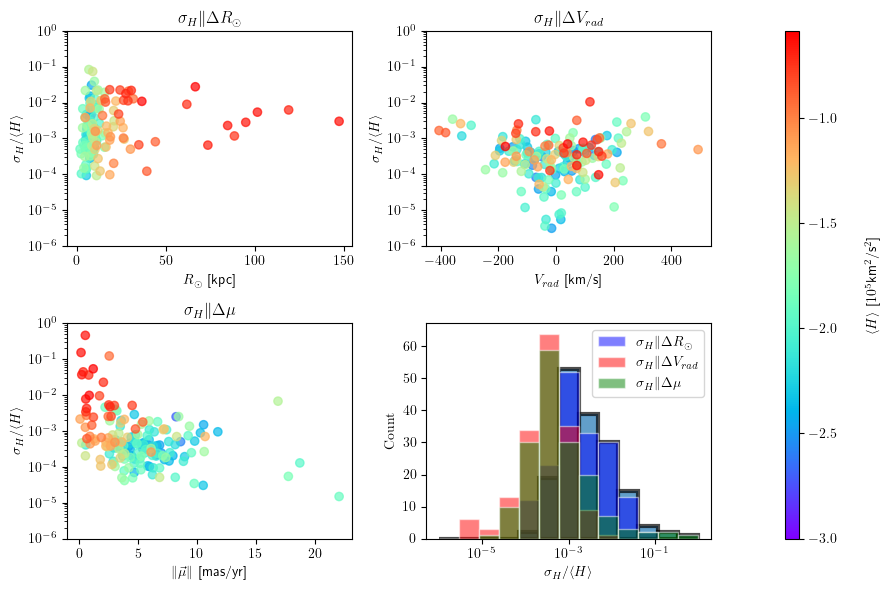

In [5]:
# make the color based on the initial orbital energy 
norm = mpl.colors.Normalize(vmin=H_means.min()//1e5, vmax=H_means.max()/1e5)
# now get the colors for each based on the mean energy
colors = plt.cm.rainbow(norm(H_means/1e5))

fig= plt.figure(figsize=(9, 6))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 0.05])
axis1 = fig.add_subplot(gs[0, 0])
axis2 = fig.add_subplot(gs[0, 1])
axis3 = fig.add_subplot(gs[1, 0])

cbar_ax = fig.add_subplot(gs[:, 2])

axis1.scatter(distances, np.abs(H_stds[:,0]/H_means), color=colors, alpha=0.7)
axis1.set_ylim(1e-6, 1)
axis1.set_yscale('log')
axis1.set_xlabel(r'$R_{\odot}$ [kpc]')
axis1.set_ylabel(r'$\sigma_{H}/\langle H \rangle$')
axis1.set_title(r'$\sigma_{H}\| \Delta R_{\odot}$')

axis2.scatter(RVs, np.abs(H_stds[:,1]/H_means), color=colors, alpha=0.7)
axis2.set_ylim(1e-6, 1)
axis2.set_yscale('log')
axis2.set_xlabel(r'$V_{rad}$ [km/s]')
axis2.set_ylabel(r'$\sigma_{H}/\langle H \rangle$')
axis2.set_title(r'$\sigma_{H}\| \Delta V_{rad}$')
axis3.scatter(total_mus, np.abs(H_stds[:,2]/H_means), color=colors, alpha=0.7)
axis3.set_ylim(1e-6, 1)
axis3.set_yscale('log')
axis3.set_xlabel(r'$\|\vec{\mu}\|$ [mas/yr]')
axis3.set_ylabel(r'$\sigma_{H}/\langle H \rangle$')
axis3.set_title(r'$\sigma_{H}\| \Delta \mu$')


axis4 = fig.add_subplot(gs[1, 1])
bins = np.logspace(-6, 0, 14)
quantity = np.abs(H_stds[:,3]/H_means)
counts = np.histogram(quantity, bins=bins)[0]
quantityD = np.abs(H_stds[:,0]/H_means)
quantityRV = np.abs(H_stds[:,1]/H_means)
quantitymu = np.abs(H_stds[:,2]/H_means)
counts_over_D = np.histogram(quantityD, bins=bins)[0]
counts_over_RV = np.histogram(quantityRV, bins=bins)[0]
counts_over_mu = np.histogram(quantitymu, bins=bins)[0]
bin_centers = 0.5 * (bins[:-1] + bins[1:])
axis4.bar(bin_centers, counts, width=np.diff(bins),         color=None, alpha=0.7, edgecolor='black',zorder=0,linewidth=3)
axis4.bar(bin_centers, counts_over_D, width=np.diff(bins),  color='blue',  edgecolor="white",  alpha=0.5, label=r'$\sigma_{H}\| \Delta R_{\odot}$')
axis4.bar(bin_centers, counts_over_RV, width=np.diff(bins), color='red',   edgecolor="white", alpha=0.5, label=r'$\sigma_{H}\| \Delta V_{rad}$')
axis4.bar(bin_centers, counts_over_mu, width=np.diff(bins), color='green', edgecolor="white", alpha=0.5, label=r'$\sigma_{H}\| \Delta \mu$')
axis4.set_xscale('log')
axis4.set_xlabel(r'$\sigma_{H}/\langle H \rangle$')
axis4.set_ylabel(r'$\mathrm{Count}$')
axis4.legend()

sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'$\langle H \rangle$ [$10^5$km$^2$/s$^2$]', labelpad=20)
fig.tight_layout()
fig.savefig("../../tempImages/energy_sensitivity_analysis_MWGCS_to_distance_RV_mu.pdf", bbox_inches='tight',dpi=300)

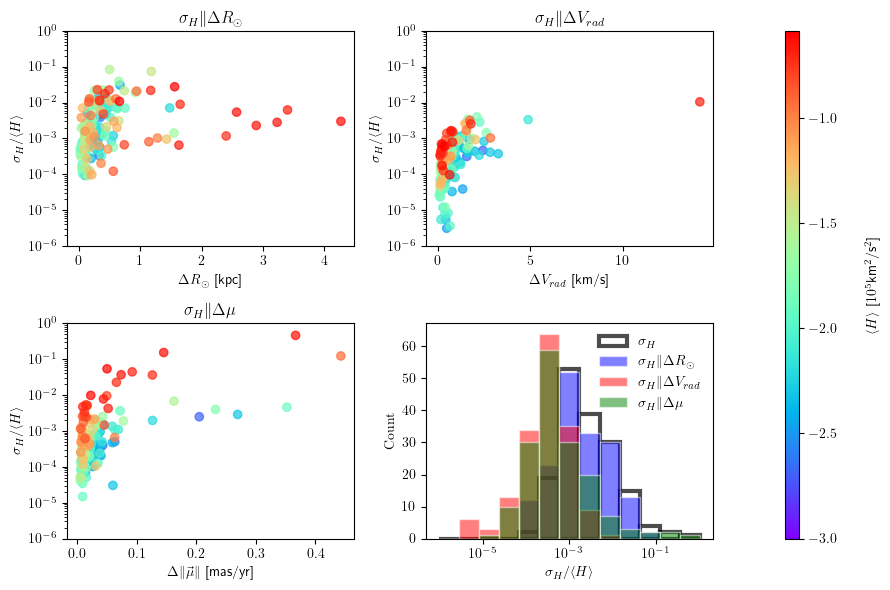

In [6]:
# make the color based on the initial orbital energy 
norm = mpl.colors.Normalize(vmin=H_means.min()//1e5, vmax=H_means.max()/1e5)
# now get the colors for each based on the mean energy
colors = plt.cm.rainbow(norm(H_means/1e5))

fig= plt.figure(figsize=(9, 6))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 0.05])
axis1 = fig.add_subplot(gs[0, 0])
axis2 = fig.add_subplot(gs[0, 1])
axis3 = fig.add_subplot(gs[1, 0])

cbar_ax = fig.add_subplot(gs[:, 2])

axis1.scatter(distances_err, np.abs(H_stds[:,0]/H_means), color=colors, alpha=0.7)
axis1.set_ylim(1e-6, 1)
axis1.set_yscale('log')
axis1.set_xlabel(r'$\Delta R_{\odot}$ [kpc]')
axis1.set_ylabel(r'$\sigma_{H}/\langle H \rangle$')
axis1.set_title(r'$\sigma_{H}\| \Delta R_{\odot}$')

axis2.scatter(RVs_err, np.abs(H_stds[:,1]/H_means), color=colors, alpha=0.7)
axis2.set_ylim(1e-6, 1)
axis2.set_yscale('log')
axis2.set_xlabel(r'$\Delta V_{rad}$ [km/s]')
axis2.set_ylabel(r'$\sigma_{H}/\langle H \rangle$')
axis2.set_title(r'$\sigma_{H}\| \Delta V_{rad}$')
axis3.scatter(total_mus_err, np.abs(H_stds[:,2]/H_means), color=colors, alpha=0.7)
axis3.set_ylim(1e-6, 1)
axis3.set_yscale('log')
axis3.set_xlabel(r'$\Delta \|\vec{\mu}\|$ [mas/yr]')
axis3.set_ylabel(r'$\sigma_{H}/\langle H \rangle$')
axis3.set_title(r'$\sigma_{H}\| \Delta \mu$')


axis4 = fig.add_subplot(gs[1, 1])
bins = np.logspace(-6, 0, 14)
quantity = np.abs(H_stds[:,3]/H_means)
counts = np.histogram(quantity, bins=bins)[0]
quantityD = np.abs(H_stds[:,0]/H_means)
quantityRV = np.abs(H_stds[:,1]/H_means)
quantitymu = np.abs(H_stds[:,2]/H_means)
counts_over_D = np.histogram(quantityD, bins=bins)[0]
counts_over_RV = np.histogram(quantityRV, bins=bins)[0]
counts_over_mu = np.histogram(quantitymu, bins=bins)[0]
bin_centers = 0.5 * (bins[:-1] + bins[1:])
axis4.bar(bin_centers, counts, width=np.diff(bins),         color="white", alpha=0.7, edgecolor='black',zorder=0,linewidth=3, label=r'$\sigma_{H}$')
axis4.bar(bin_centers, counts_over_D, width=np.diff(bins),  color='blue',  edgecolor="white",  alpha=0.5, label=r'$\sigma_{H}\| \Delta R_{\odot}$')
axis4.bar(bin_centers, counts_over_RV, width=np.diff(bins), color='red',   edgecolor="white", alpha=0.5, label=r'$\sigma_{H}\| \Delta V_{rad}$')
axis4.bar(bin_centers, counts_over_mu, width=np.diff(bins), color='green', edgecolor="white", alpha=0.5, label=r'$\sigma_{H}\| \Delta \mu$')
axis4.set_xscale('log')
axis4.set_xlabel(r'$\sigma_{H}/\langle H \rangle$')
axis4.set_ylabel(r'$\mathrm{Count}$')
axis4.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'$\langle H \rangle$ [$10^5$km$^2$/s$^2$]', labelpad=20)
fig.tight_layout()

fig.savefig("../../tempImages/energy_sensitivity_analysis_MWGCS_to_errors.pdf", bbox_inches='tight',dpi=300)

Phase mixing for a cluster WITHOUT a central force and then one with one

In [7]:
GCname = "Rup106"
clusters=tstrippy.Parsers.baumgardtMWGCs()
mean,cov=clusters.getGCCovarianceMatrix(GCname)
RA,DEC,Rsun,RV,mualpha,mu_delta,Mass,rh_m=mean
# put this in galactocentric coordinates
# put the coordinates on the sky 
skycoords=coord.sky_coordinate.SkyCoord(
    ra = RA * u.deg,
    dec = DEC * u.deg,
    distance = Rsun * u.kpc,
    radial_velocity = RV * u.km / u.s,
    pm_ra_cosdec = mualpha * u.mas / u.yr,
    pm_dec = mu_delta * u.mas / u.yr,)
galactocentric=skycoords.transform_to(coord.Galactocentric)
# extact the galacticentric coordinates
xc,yc,zc = galactocentric.x.value, galactocentric.y.value, galactocentric.z.value
vxc,vyc,vzc = galactocentric.v_x.value, galactocentric.v_y.value, galactocentric.v_z.value

In [8]:
MWparams = tstrippy.Parsers.pouliasis2017pii()
rplum = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(rh_m)
plumParams = [MWparams[0],Mass,rplum]


In [9]:
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(MWparams[0],Mass,rh_m,int(5e2))

In [10]:
# Find the mixing time of the system
_,_,_,phiMW=tstrippy.potentials.pouliasis2017pii(MWparams, xp+xc, yp+yc, zp+zc)
_,_,_,phiGC=tstrippy.potentials.plummer(plumParams,xp,yp,zp)
kineticEnergy = 0.5 * ((vxp+vxc)**2 + (vyp+vyc)**2 + (vzp+vzc)**2)
totalEnergy = kineticEnergy + phiMW + phiGC
# get the mean and spread of the total energy
meanE = np.mean(totalEnergy)
stdE = np.std(totalEnergy)
